In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons, make_blobs
from sklearn.linear_model import LogisticRegression
from scipy.special import logit, expit

# Визуализация

In [2]:
def visualize(clf, X, y):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_border = (x_max - x_min) / 20 + 1.0e-3
    x_h = (x_max - x_min + 2 * x_border) / 200
    y_border = (y_max - y_min) / 20 + 1.0e-3
    y_h = (y_max - y_min + 2 * y_border) / 200
    
    cm = plt.cm.Spectral

    xx, yy = np.meshgrid(np.arange(x_min - x_border, x_max + x_border, x_h), np.arange(y_min - y_border, y_max + y_border, y_h))
    mesh = np.c_[xx.ravel(), yy.ravel()]

    z_class = clf.predict(mesh).reshape(xx.shape)

    # Put the result into a color plot
    plt.figure(1, figsize=(8, 8))
    plt.pcolormesh(xx, yy, z_class, cmap=cm, alpha=0.3, shading='gouraud')

    # Plot hyperplane and margin
    z_dist = clf.decision_function(mesh).reshape(xx.shape)
    plt.contour(xx, yy, z_dist, [0.0], colors='black')

    # Plot also the training points
    y_pred = clf.predict(X)

    ind_support = []
    ind_correct = []
    ind_incorrect = []
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            ind_correct.append(i)
        else:
            ind_incorrect.append(i)

    plt.scatter(X[ind_correct, 0], X[ind_correct, 1], c=y[ind_correct], cmap=cm, alpha=1., edgecolor='black', linewidth=.8)
    plt.scatter(X[ind_incorrect, 0], X[ind_incorrect, 1], c=y[ind_incorrect], cmap=cm, alpha=1., marker='*',
               s=50, edgecolor='black', linewidth=.8)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.tight_layout()

# Данные

In [3]:
def generate_dataset():
    X, y = make_blobs([1000, 500], 2, centers=[[0, 0], [10, 10]], cluster_std=[5,2], random_state=7)
    return X, y

X, y = generate_dataset()

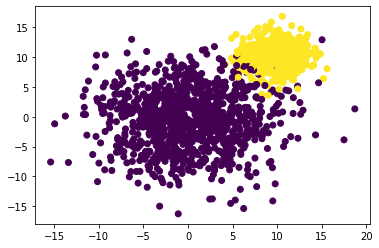

In [4]:
plt.scatter(X[:,0], X[:,1], c=y)

In [5]:
def generate_pu_labels(y, c=0.2):
    nz_inds = np.nonzero(y)[0]
    pos_inds = np.random.choice(nz_inds, int(len(nz_inds) * c), replace=False)
    s = np.zeros_like(y)
    s[pos_inds] = 1
    return s

y_pu = generate_pu_labels(y, c=0.2)

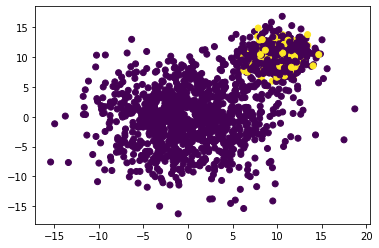

In [6]:
plt.scatter(X[:,0], X[:,1], c=y_pu)

# Логистическая регрессия

In [7]:
class LogReg(LogisticRegression):
    def squares(self, X):
        if len(X.shape) == 1:
            return np.array([*X, X[0]*X[1], X[0]**2, X[1]**2])
        a, b = X[:, 0], X[:, 1]
        return np.c_[a, b, a*b, a**2, b**2]
        
    def fit(self, X, y):
        return super().fit(self.squares(X), y)
    
    def decision_function(self, X):
        return super().decision_function(self.squares(X))

In [8]:
clf = LogReg()
clf.fit(X, y)
clf.score(X, y)

0.986

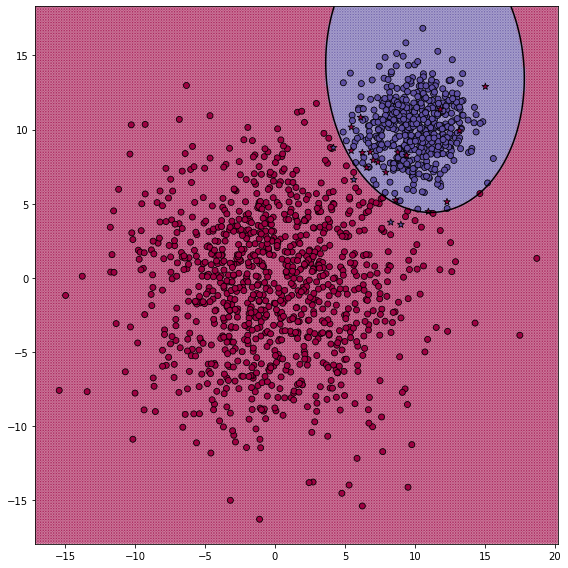

In [9]:
visualize(clf, X, y)

# PU classifier

In [10]:
class PUClassifier(LogReg):
    def __init__(self, **kargs):
        self.clf = LogReg(**kargs)
        super().__init__(**kargs)
    
    def fit(self, X, y, n=20):
        self.clf.fit(X, y)
        
        # Оценка параметра c
        nonzero_inds = np.nonzero(y)[0]
        inds = np.random.choice(nonzero_inds, n, replace=False)
        self.c = np.mean(self.clf.predict_proba(X)[inds, 1])
    
    def predict_proba(self, X):
        probs = self.clf.predict_proba(X)
        new_p = np.clip(probs[:, 1]/self.c, 0, 1)
        return np.c_[1 - new_p, new_p]
    
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)
    
    def decision_function(self, X):
        probs = self.predict_proba(X)
        return logit(probs[:, 1])

In [58]:
pu = PUClassifier()
pu.fit(X, y_pu, n=10)
pu.score(X, y)

0.9793333333333333

Классификатор хорошо работает даже если оставлять всего 20% всех точек одного класса.

In [59]:
pu.c

0.1898307042472612

Оценка доли оставленных в положительном классе точек тоже близка к правде, в `generate_pu_labels` было выбрано `c=0.2`.

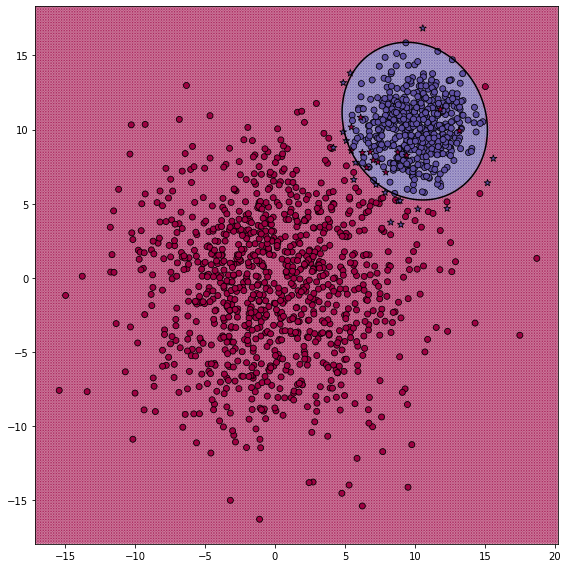

In [60]:
visualize(pu, X, y)

Видно, что классификатор хорошо выделил положительный `blob`. А граница между положительным и негативным классом схожа с таковой у идеального классификатора.